In [ ]:
%pip install vit_pytorch timm

In [67]:
from vit_pytorch import ViT

class DeepfakeClassifier(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2, output_dim=2):
        super(DeepfakeClassifier, self).__init__()
        
        # Load pre-trained ViT model
        self.vit = ViT(
            image_size=224,
            patch_size=16,
            num_classes=1024,  # Set this to 1024 if you want 1024-dimensional features
            dim=768,          # Feature dimension
            depth=6,           # Number of transformer layers
            heads=16,          # Number of attention heads
            mlp_dim=2048,      # Dimension of feed-forward layers
            dropout=0.1,
            emb_dropout=0.1
        )
        
        # Initialize LSTM for temporal sequence processing
        self.lstm = nn.LSTM(input_size=1024, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Final fully connected layer for binary classification (real or fake)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Args:
            x: A tensor of shape (batch_size, seq_len, C, H, W)
        Returns:
            output: Binary classification output (real/fake)
        """
        batch_size, seq_len, C, H, W = x.shape
        
        # Feature extraction using pre-trained ViT for each frame
        features = []
        for t in range(seq_len):
            frame_features = self.vit(x[:, t, :, :, :])  # ViT processes one frame at a time
            features.append(frame_features)
        
        # Stack features along the time axis for LSTM input
        features = torch.stack(features, dim=1)  # Shape: (batch_size, seq_len, 1024)
        
        # Pass the sequence of frame features through LSTM
        lstm_out, _ = self.lstm(features)  # Shape: (batch_size, seq_len, hidden_dim)
        
        # Use the output from the last LSTM time step for classification
        output = self.fc(lstm_out[:, -1, :])  
        
        return output


In [65]:
import torch
from torch.utils.data import Dataset
import cv2
import os
from glob import glob
from PIL import Image
from torchvision import transforms

# Disable OpenCL in OpenCV
cv2.ocl.setUseOpenCL(False)

class VideoDataset(Dataset):
    def __init__(self, video_dir, label_map, transform=None, frame_count=16, frame_size=(224, 224)):
        """
        Args:
            video_dir (string): Path to the directory containing videos (real/synthetic).
            label_map (dict): Dictionary mapping 'real' -> 0, 'synthetic' -> 1.
            transform (callable, optional): Optional transform to apply to video frames.
            frame_count (int): Number of frames to extract from each video.
            frame_size (tuple): Desired frame size (H, W) for resizing.
        """
        self.video_dir = video_dir
        self.label_map = label_map
        self.transform = transform
        self.frame_count = frame_count
        self.frame_size = frame_size

        # Load face detector (initialize only in the main process)
        self.face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        
        self.video_list = self.get_video_list()

    def get_video_list(self):
        """Returns a list of all video file paths and corresponding labels."""
        video_list = []
        for label, label_id in self.label_map.items():
            label_path = os.path.join(self.video_dir, label)
            videos = glob(os.path.join(label_path, '*.mp4'))  # Assuming videos are .mp4 files
            video_list.extend([(video, label_id) for video in videos])
        return video_list

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        video_path, label = self.video_list[idx]
        frames = self.extract_frames(video_path)

        # Apply transformations to each frame
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        # Stack frames along the time axis (seq_len)
        frames = torch.stack(frames)  # Shape: (frame_count, 3, H, W)

        return frames, label

    def extract_frames(self, video_path):
        """Extract a fixed number of frames from a video."""
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames == 0:
            cap.release()
            raise ValueError(f"Failed to read frames from video: {video_path}")

        frame_idxs = torch.linspace(0, total_frames - 1, steps=self.frame_count).long()

        frames = []
        face_cascade = cv2.CascadeClassifier(self.face_cascade_path)  # Initialize face detector here
        
        for idx in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx.item())
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                frame = self.detect_and_crop_face(frame, face_cascade)  # Crop to the face
                frame = Image.fromarray(frame)  # Convert NumPy array to PIL Image
                frame = frame.resize(self.frame_size, Image.Resampling.BILINEAR)  # Resize to the desired frame size
                frames.append(frame)
            else:
                # Handle the case where a frame could not be read
                frames.append(Image.new('RGB', self.frame_size))  # Append a blank image if frame read fails

        cap.release()

        if len(frames) < self.frame_count:
            # If fewer frames are extracted, repeat the last frame to match the required frame count
            while len(frames) < self.frame_count:
                frames.append(frames[-1])

        return frames

    def detect_and_crop_face(self, frame, face_cascade):
        """Detect and crop face from the frame."""
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale for face detection
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        if len(faces) > 0:
            # Use the first detected face
            (x, y, w, h) = faces[0]
            # Ensure the cropping is within frame bounds
            x, y, w, h = max(0, x), max(0, y), min(frame.shape[1], x + w), min(frame.shape[0], y + h)
            frame = frame[y:h, x:w]  # Crop to the face
        else:
            # If no face is detected, return the original frame or handle as needed
            frame = frame  # No cropping
        
        # Check if the frame is too small and resize if necessary
        if frame.shape[0] == 0 or frame.shape[1] == 0:
            frame = cv2.resize(frame, (self.frame_size[1], self.frame_size[0]), interpolation=cv2.INTER_LINEAR)
        else:
            frame = cv2.resize(frame, (self.frame_size[1], self.frame_size[0]), interpolation=cv2.INTER_LINEAR)
        
        return frame


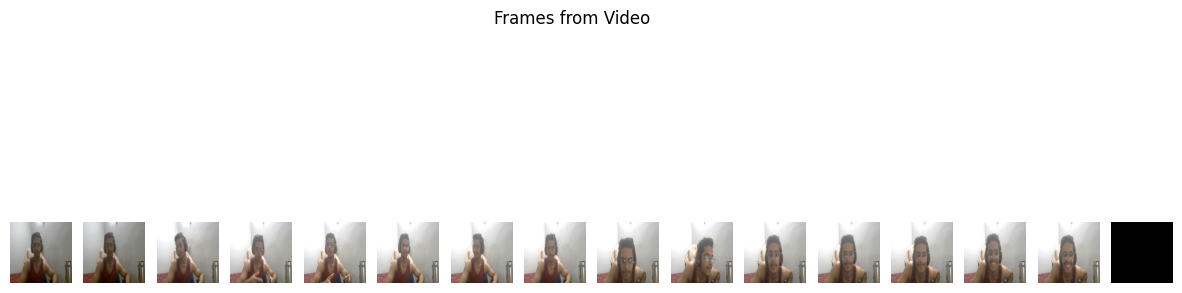

In [45]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def test_video_loading(video_path, frame_count=16, frame_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print(f"Failed to read frames from video: {video_path}")
        return

    frame_idxs = torch.linspace(0, total_frames - 1, steps=frame_count).long()
    frames = []
    
    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx.item())
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            frame = Image.fromarray(frame)  # Convert NumPy array to PIL Image
            frame = frame.resize(frame_size, Image.Resampling.BILINEAR)  # Resize to the desired frame size
            frames.append(frame)
        else:
            frames.append(Image.new('RGB', frame_size))  # Append a blank image if frame read fails

    cap.release()

    # Display the frames
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for ax, frame in zip(axes, frames):
        ax.imshow(frame)
        ax.axis('off')

    plt.suptitle('Frames from Video')  # Display title
    plt.show()

# Test the specific video file
video_path = 'C:\\Users\\bhatt\\Machine Learning\\SIH\\test_vid.mp4'  # Path to your video file
test_video_loading(video_path)


In [57]:
import torch
torch.cuda.empty_cache()



In [59]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print("CUDA is available!")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"\nGPU {i}:")
            print(f"  Name: {torch.cuda.get_device_name(i)}")
            print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / (1024**3):.2f} GB")
            print(f"  Memory Cached: {torch.cuda.memory_reserved(i) / (1024**3):.2f} GB")
    else:
        print("CUDA is not available. Please check your installation.")

if __name__ == '__main__':
    check_cuda()


CUDA is available!
Number of GPUs: 1

GPU 0:
  Name: NVIDIA GeForce GTX 1650
  Memory Allocated: 3.31 GB
  Memory Cached: 3.46 GB


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torchvision import transforms
import numpy as np
import logging
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm  # Import tqdm for progress bars

# Set up logging
logging.basicConfig(filename='training_log.log', level=logging.INFO)

# Define training and validation transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Paths and label mapping
video_dir = "C:\\ML Resources\\Celeb_videos\\celebDataset\\celebDataset"  # Replace with your video directory path
label_map = {'real': 0, 'synthetic': 1}

# Create dataset and dataloaders
train_dataset = VideoDataset(video_dir=video_dir, label_map=label_map, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)  # Reduced batch size

# Initialize the model
model = DeepfakeClassifier()
device = torch.device('cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Mixed precision scaler
scaler = GradScaler()

def train_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs):
    model.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_labels = []
        all_preds = []
        
        model.train()  # Set model to training mode
        
        # Create a progress bar for the epoch
        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit='batch')

        for inputs, labels in epoch_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():  # Mixed precision context
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Collect predictions and labels for accuracy calculation
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
        
        # Logging metrics
        logging.info(f"Epoch {epoch + 1}/{num_epochs}")
        logging.info(f"Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
        
        # Step the learning rate scheduler
        scheduler.step()
        
        # Clear GPU cache
        torch.cuda.empty_cache()
        
    # Save the model
    torch.save(model.state_dict(), 'deepfake_classifier.pth')
    logging.info("Model saved to 'deepfake_classifier.pth'")

# Example usage
num_epochs = 1
train_model(model, train_loader, criterion, optimizer, scheduler, device, num_epochs)


In [ ]:
import torch

def save_model(model, path='deepfake_classifier.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model state dictionary saved to {path}")

# Example usage
save_model(model, 'deepfake_classifier.pth')
